# W261 Final: Click Through Rate (CTR) Prediction Using Criteo Ad Data

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, LongType
from pyspark.ml.stat import Correlation
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_eda_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

### Look at training data

In [52]:
# take a look
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# Count the number of records in the raw data
!wc -l data/train.txt

45840617 data/train.txt


In [6]:
# Count the number of records in the raw data
!wc -l data/test.txt

6042135 data/test.txt


### Create training sets

In [54]:
#!head -n 4000000 data/train.txt > data/train_4m.txt
#!head -n 1000000 data/train.txt > data/train_1m.txt
#!head -n 100000 data/train.txt  > data/train_100K.txt

In [55]:
smallRDD = sc.textFile('data/train_1m.txt')
#smallRDD = sc.textFile('data/train_100K.txt')
#smallRDD = sc.textFile('data/small.txt')

### Get the number of columns

In [56]:
smallRDDRow = smallRDD.take(1)
numColumns = len(smallRDDRow[0].split('\t'))
print('The number of columns is: {}'.format(numColumns))

The number of columns is: 40


### Create a function to split the lines and convert into numbers

In [57]:
def ConvertNumber(idx, num):
    if num != '':
        if idx > 13:
            return int(num, 16)
        else:
            return int(num)
    else:
        return None

In [58]:
smallRDD2 = smallRDD.map(lambda x: [ConvertNumber(idx, num) for idx,num in enumerate(x.split('\t'))]).cache()

### Create a DataFrame

In [59]:
structFieldList = [StructField('field_' + str(num), LongType(), True) for num in range(numColumns)]
schema = StructType(structFieldList)
testDF = spark.createDataFrame(smallRDD2, schema)

### Create a function to display information about a column

In [61]:
click_data = testDF.select('field_0').rdd.flatMap(lambda x: x).collect()

In [62]:
def columnEDA(field_num):

    # Describe the columns
    if field_num < 14:
        fieldList = ['field_'+str(field_num)]
        testDF.describe(fieldList).show()

    # Distinct counts for this column
    fieldStr = "field_" + str(field_num)
    testGroupedDF = testDF.filter(fieldStr + " is not NULL").groupBy(fieldStr).count()
    count_list = testGroupedDF.select('count').rdd.flatMap(lambda x: x).collect()
    print('Number of distinct values: {}'.format(len(count_list)))
    
    # Number of null values
    num_null_values = testDF.select(fieldStr).rdd.flatMap(lambda x: x).filter(lambda x: x == None).count()
    print('Number of null values is: {}'.format(num_null_values))
    
    # Plot the histogram
    count_list = testDF.select(fieldStr).rdd.flatMap(lambda x: x).filter(lambda x: x != None).collect()
    plt.hist(count_list, bins=100)
    plt.title("Distribution of unique " + fieldStr + " values")
    plt.show()
    
    # Plot time series
    if field_num != 0:
        field_data = testDF.select(fieldStr).rdd.flatMap(lambda x: x).collect()
        
        plt.figure(figsize=(16,4))
        
        if field_num < 14:
            plt.plot(field_data, 'b-') # Line for continuous data
        else:
            plt.plot(field_data, 'b.') # Points for hash data
        
        plt.title(fieldStr + " time series")
        plt.show()
    
    # Plot field v. click
    if field_num != 0:
        plt.figure(figsize=(16,4))
        sns.boxplot(field_data, click_data, orient='h', linewidth=.5)
        plt.title(fieldStr + " v. click")
        plt.show()

### Correlations

In [72]:
#num_corr_fields = 2
num_corr_fields = numColumns

corr = np.zeros(shape=(num_corr_fields,num_corr_fields))
testFields = ['field_' + str(num) for num in range(num_corr_fields)]

for iidx in range(len(testFields)):
    for jidx in range(iidx):
        corr[iidx, jidx] = testDF.stat.corr(testFields[iidx], testFields[jidx])

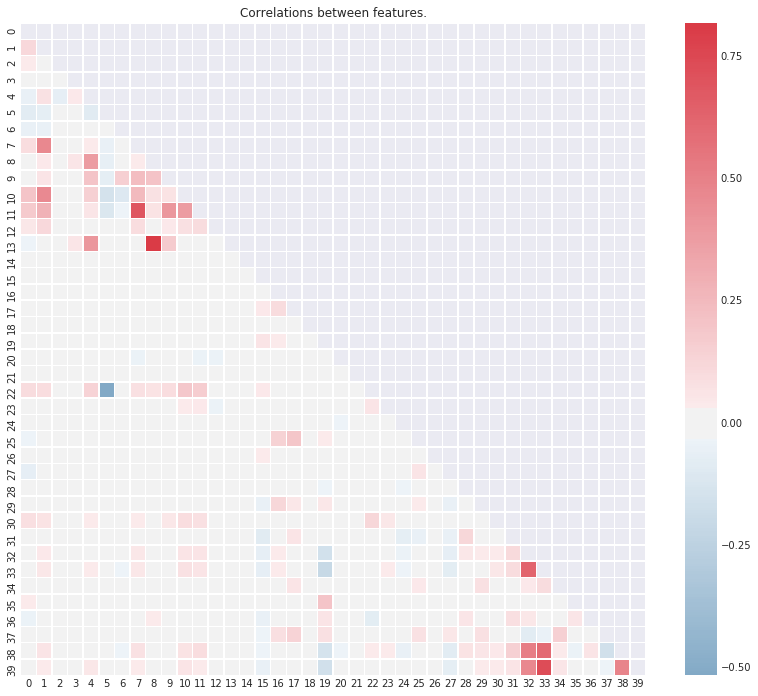

In [77]:
plt.figure(figsize=(14,12))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

### Show information about all the columns

----------------------------------------------------------------------------------------------
Information for column: 0

+-------+-------------------+
|summary|            field_0|
+-------+-------------------+
|  count|            1000000|
|   mean|           0.254949|
| stddev|0.43583276305160557|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

Number of distinct values: 2
Number of null values is: 0


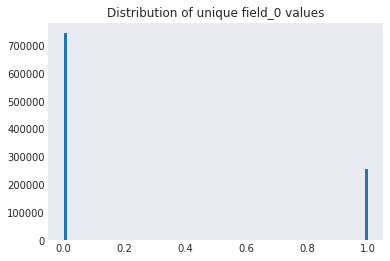

----------------------------------------------------------------------------------------------
Information for column: 1

+-------+------------------+
|summary|           field_1|
+-------+------------------+
|  count|            576997|
|   mean|3.2383998530321647|
| stddev| 8.944151450345608|
|    min|                 0|
|    max|               780|
+-------+------------------+

Number of distinct values: 265
Number of null values is: 423003


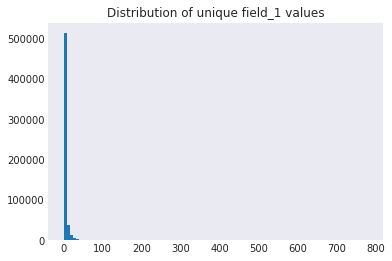

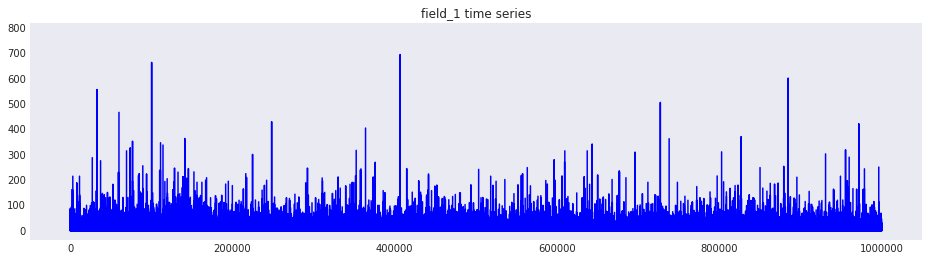

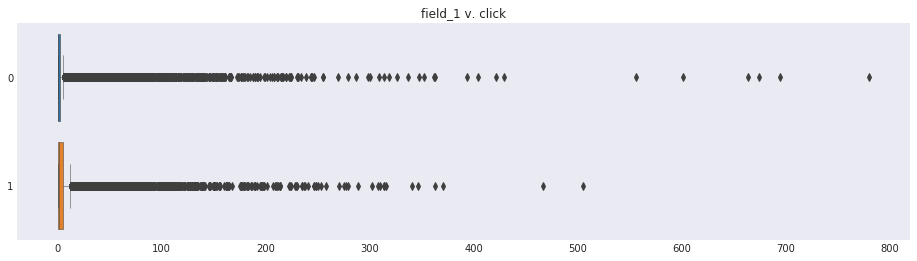

----------------------------------------------------------------------------------------------
Information for column: 2

+-------+------------------+
|summary|           field_2|
+-------+------------------+
|  count|           1000000|
|   mean|         93.965184|
| stddev|349.88467487321026|
|    min|                -2|
|    max|             18522|
+-------+------------------+

Number of distinct values: 4061
Number of null values is: 0


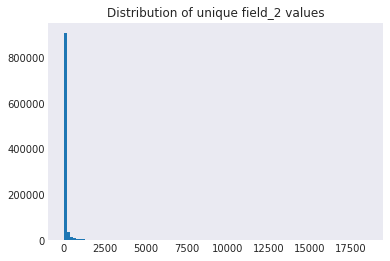

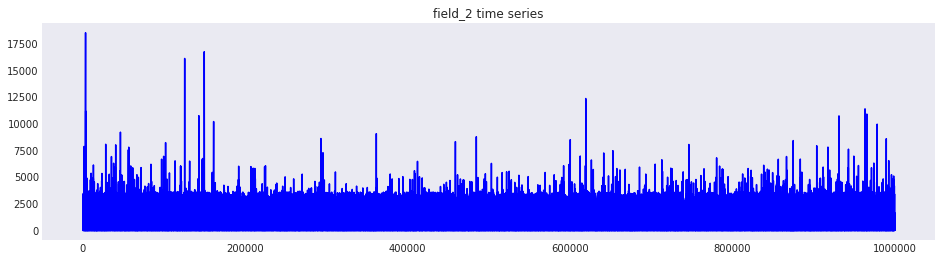

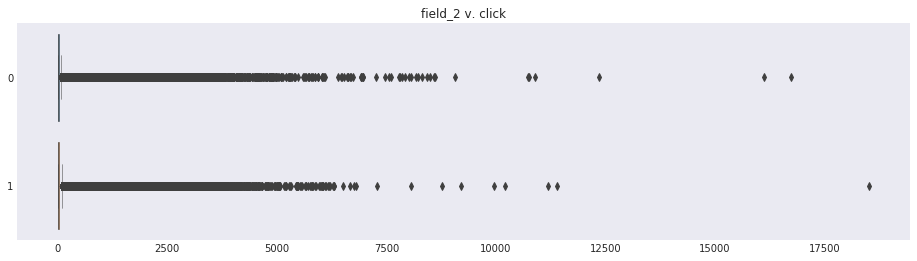

----------------------------------------------------------------------------------------------
Information for column: 3

+-------+------------------+
|summary|           field_3|
+-------+------------------+
|  count|            764946|
|   mean|21.094269399408585|
| stddev| 344.0100014840379|
|    min|                 0|
|    max|             65535|
+-------+------------------+

Number of distinct values: 1719
Number of null values is: 235054


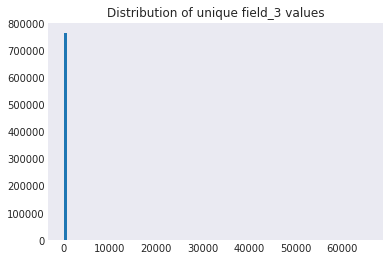

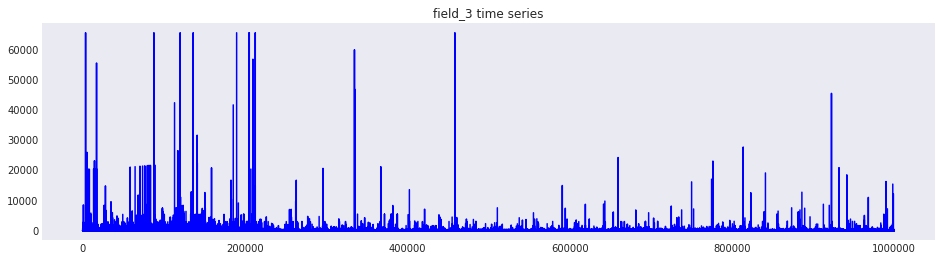

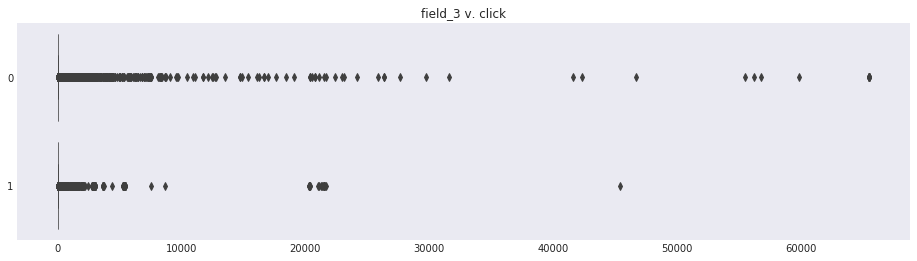

----------------------------------------------------------------------------------------------
Information for column: 4

+-------+-----------------+
|summary|          field_4|
+-------+-----------------+
|  count|           750884|
|   mean|6.954269900543892|
| stddev| 8.55401438574898|
|    min|                0|
|    max|              507|
+-------+-----------------+

Number of distinct values: 193
Number of null values is: 249116


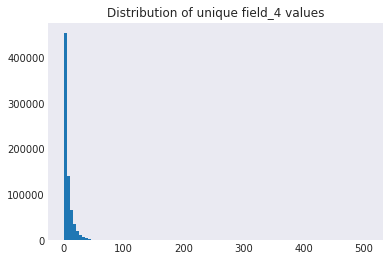

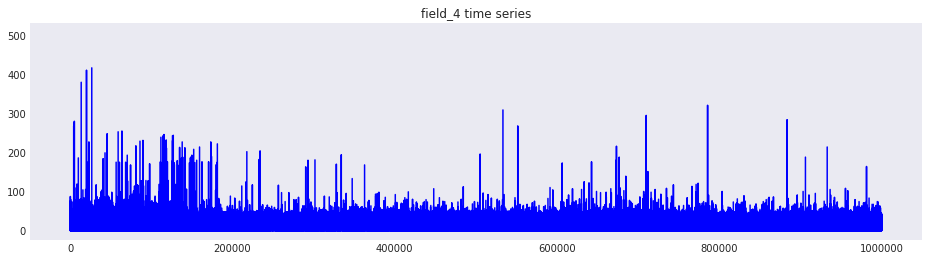

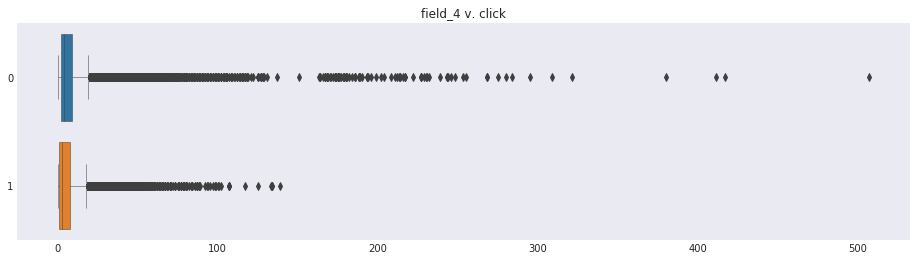

----------------------------------------------------------------------------------------------
Information for column: 5

+-------+------------------+
|summary|           field_5|
+-------+------------------+
|  count|            975464|
|   mean|18616.531734641154|
| stddev| 67686.65114895493|
|    min|                 0|
|    max|           2527030|
+-------+------------------+

Number of distinct values: 79185
Number of null values is: 24536


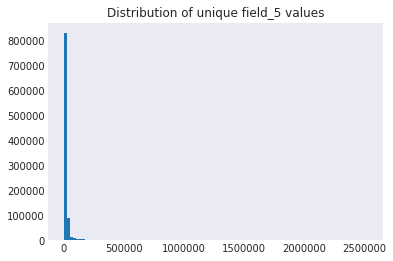

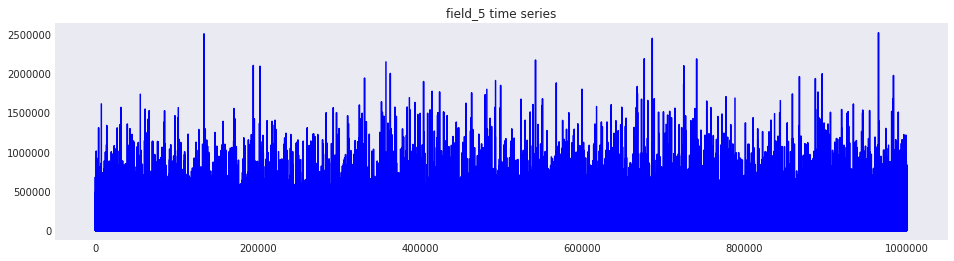

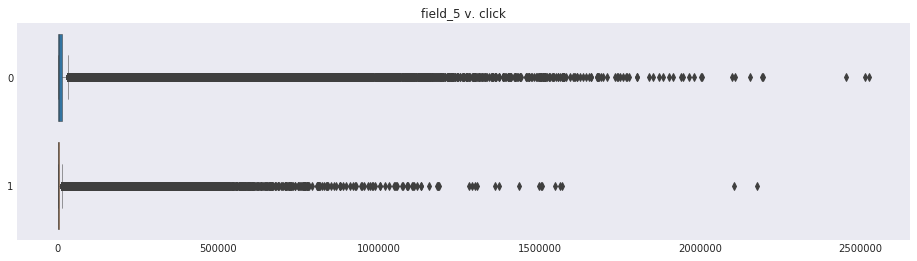

----------------------------------------------------------------------------------------------
Information for column: 6

+-------+------------------+
|summary|           field_6|
+-------+------------------+
|  count|            778260|
|   mean|116.76165291804796|
| stddev| 456.0568471068564|
|    min|                 0|
|    max|            233523|
+-------+------------------+

Number of distinct values: 3936
Number of null values is: 221740


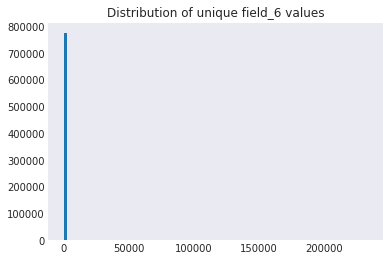

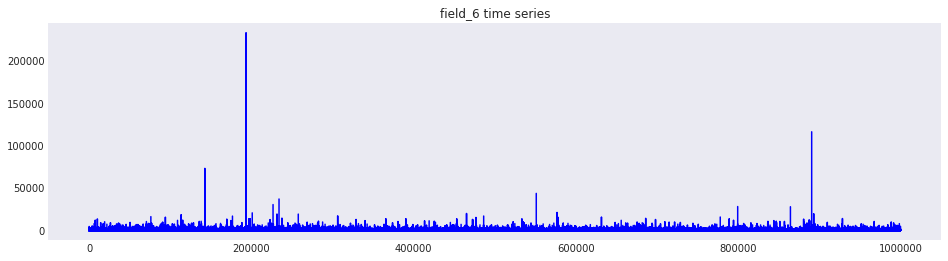

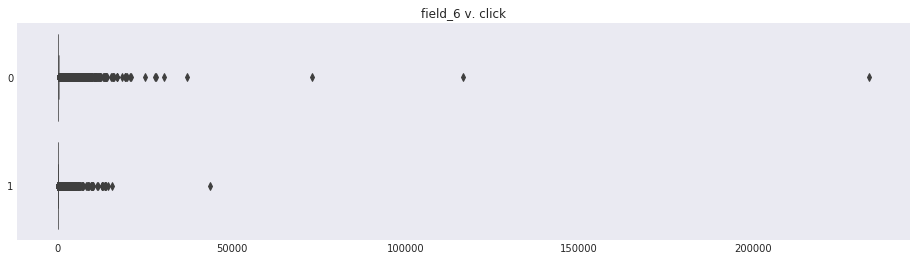

----------------------------------------------------------------------------------------------
Information for column: 7

+-------+------------------+
|summary|           field_7|
+-------+------------------+
|  count|            959166|
|   mean|14.592223869486617|
| stddev|58.277458822211884|
|    min|                 0|
|    max|              8807|
+-------+------------------+

Number of distinct values: 1321
Number of null values is: 40834


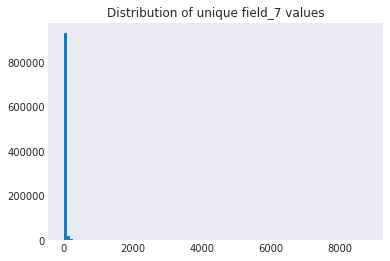

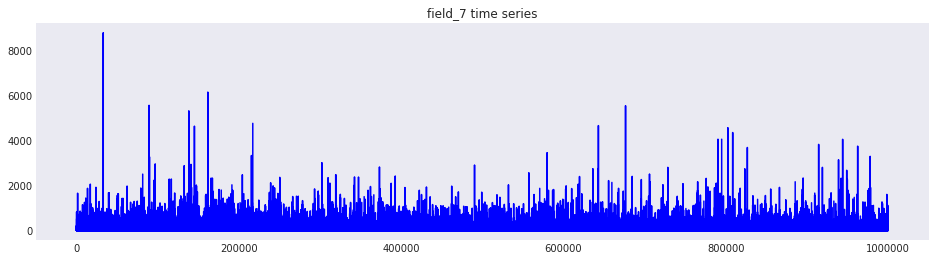

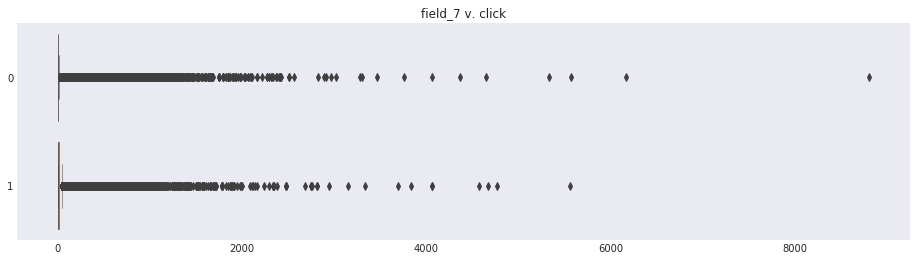

----------------------------------------------------------------------------------------------
Information for column: 8

+-------+------------------+
|summary|           field_8|
+-------+------------------+
|  count|            999338|
|   mean|13.378893827713947|
| stddev|32.345836197608186|
|    min|                 0|
|    max|              5064|
+-------+------------------+

Number of distinct values: 338
Number of null values is: 662


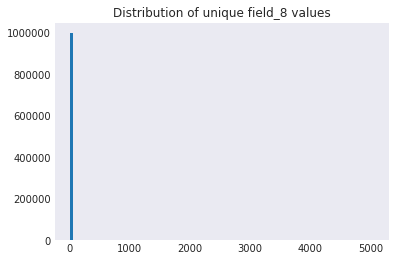

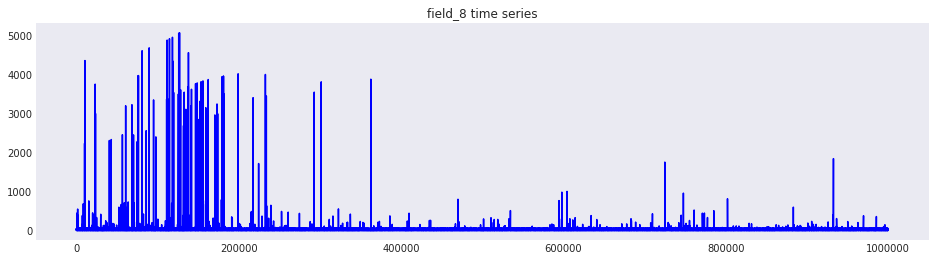

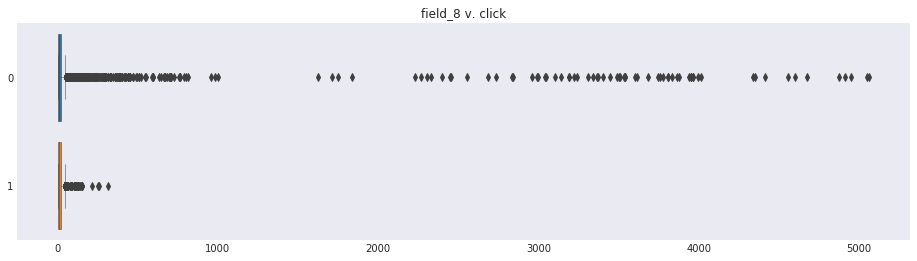

----------------------------------------------------------------------------------------------
Information for column: 9

+-------+-----------------+
|summary|          field_9|
+-------+-----------------+
|  count|           959166|
|   mean|105.4509313299262|
| stddev|217.4054007913265|
|    min|                0|
|    max|            19327|
+-------+-----------------+

Number of distinct values: 3088
Number of null values is: 40834


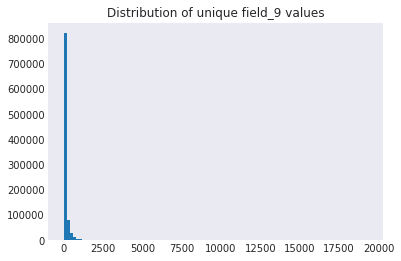

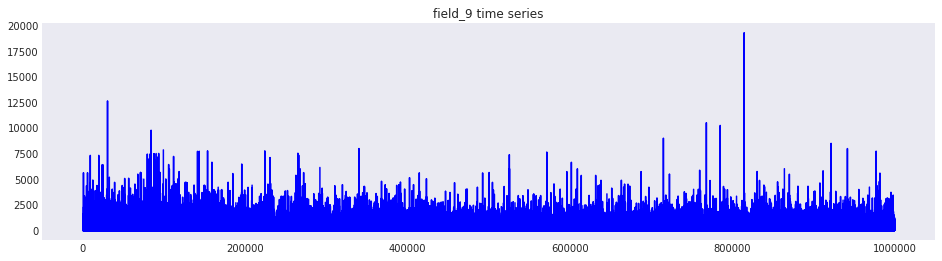

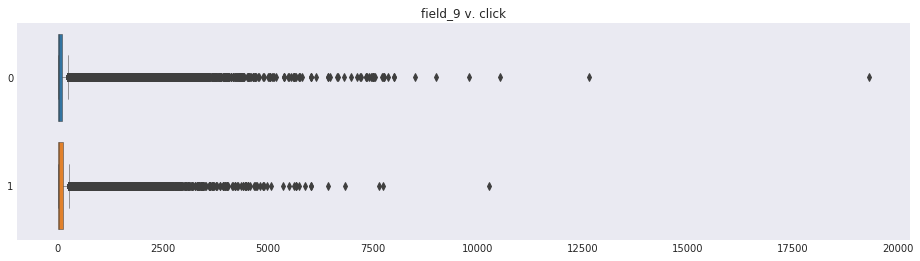

----------------------------------------------------------------------------------------------
Information for column: 10

+-------+------------------+
|summary|          field_10|
+-------+------------------+
|  count|            576997|
|   mean|0.5726580900767249|
| stddev|0.6799365576169457|
|    min|                 0|
|    max|                 8|
+-------+------------------+

Number of distinct values: 9
Number of null values is: 423003


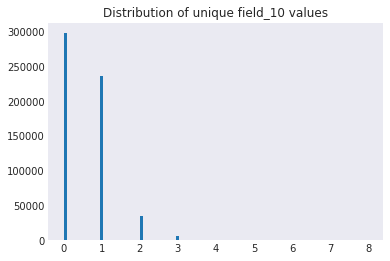

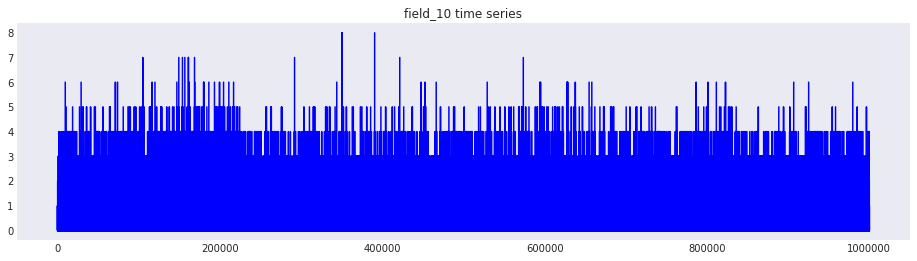

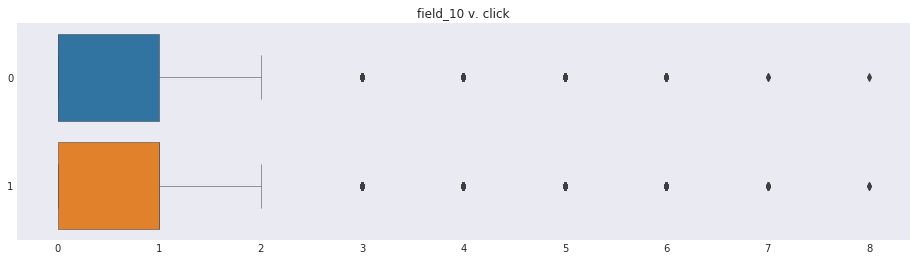

----------------------------------------------------------------------------------------------
Information for column: 11

+-------+------------------+
|summary|          field_11|
+-------+------------------+
|  count|            959166|
|   mean|2.5074491798082916|
| stddev|4.8253700829179955|
|    min|                 0|
|    max|               147|
+-------+------------------+

Number of distinct values: 122
Number of null values is: 40834


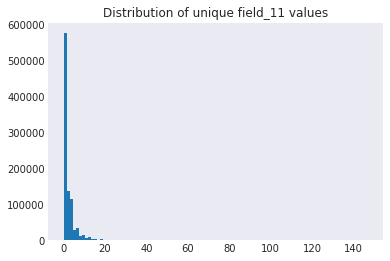

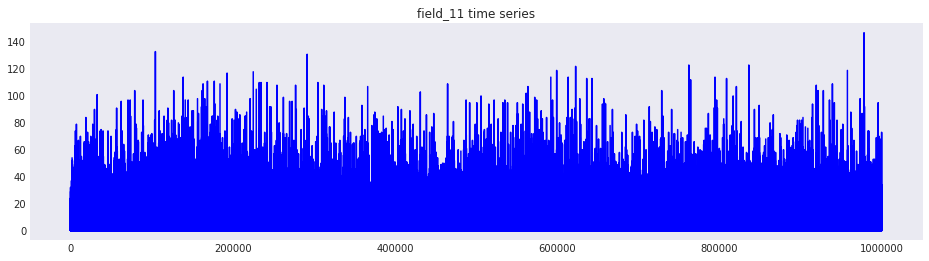

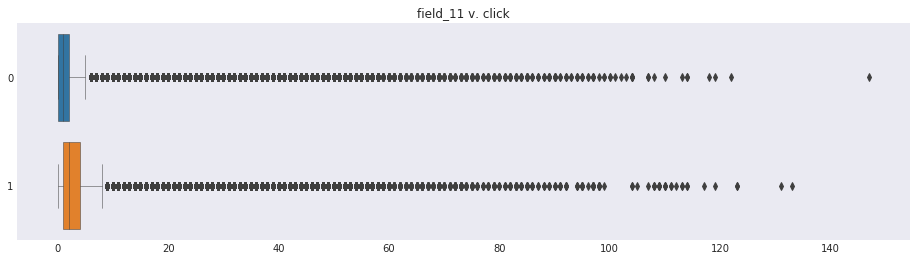

----------------------------------------------------------------------------------------------
Information for column: 12

+-------+------------------+
|summary|          field_12|
+-------+------------------+
|  count|            229943|
|   mean|0.9799906933457422|
| stddev| 6.003873979190449|
|    min|                 0|
|    max|               768|
+-------+------------------+

Number of distinct values: 160
Number of null values is: 770057


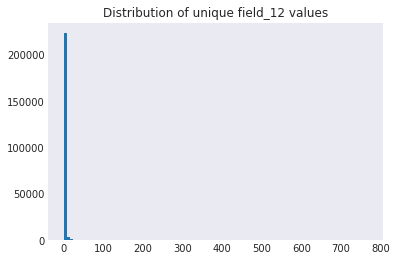

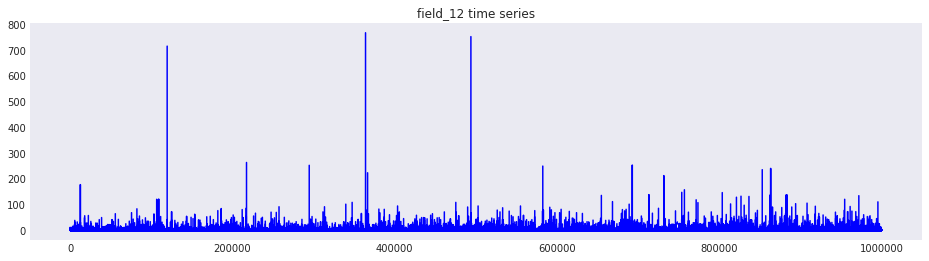

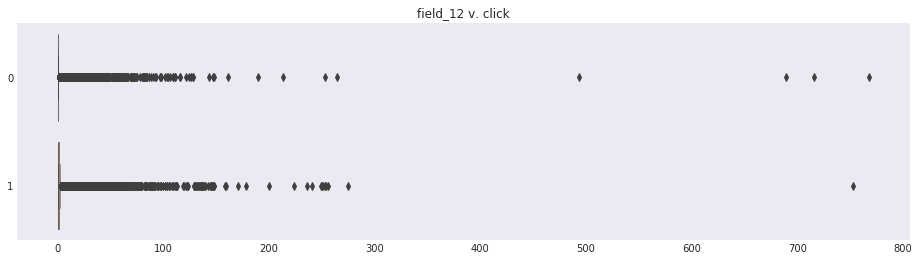

----------------------------------------------------------------------------------------------
Information for column: 13

+-------+-----------------+
|summary|         field_13|
+-------+-----------------+
|  count|           750884|
|   mean|7.630002770068346|
| stddev|35.07148738167048|
|    min|                0|
|    max|             6702|
+-------+-----------------+

Number of distinct values: 387
Number of null values is: 249116


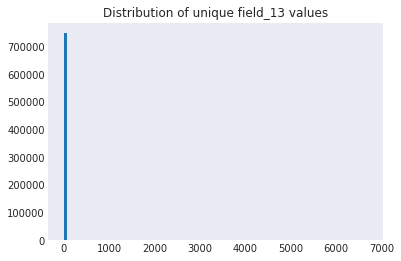

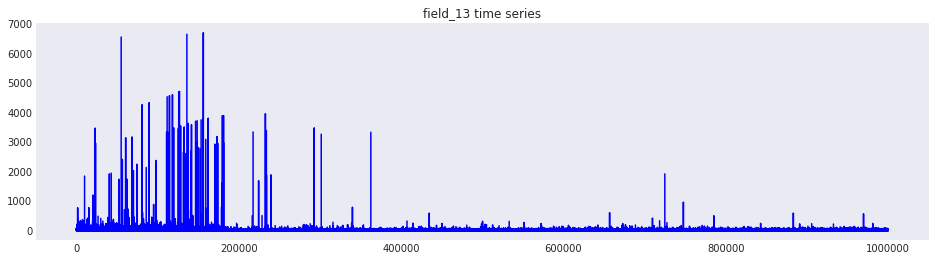

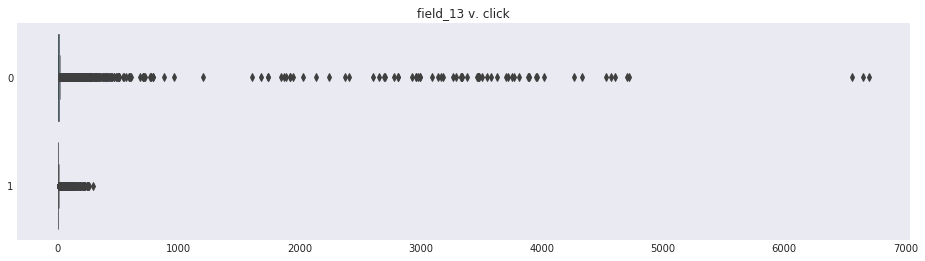

----------------------------------------------------------------------------------------------
Information for column: 14

Number of distinct values: 1261
Number of null values is: 0


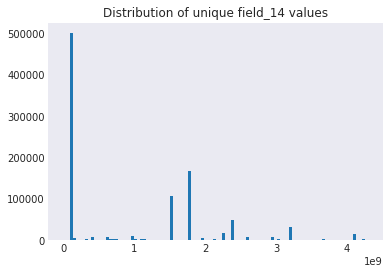

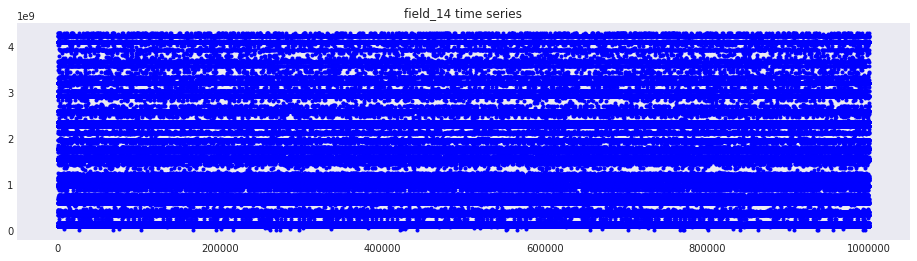

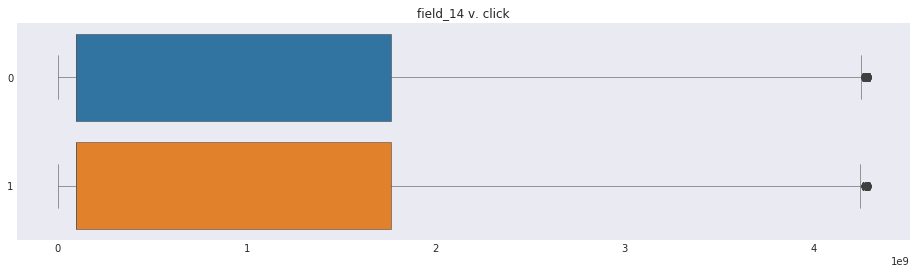

----------------------------------------------------------------------------------------------
Information for column: 15

Number of distinct values: 531
Number of null values is: 0


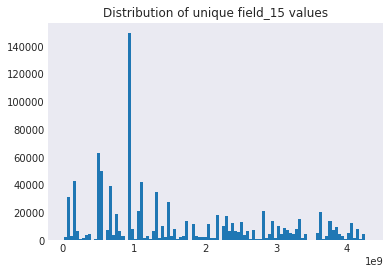

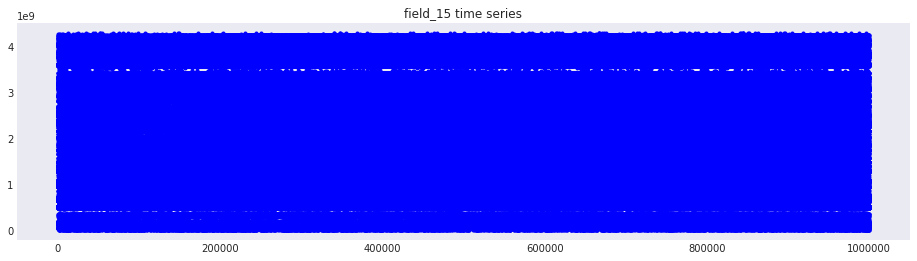

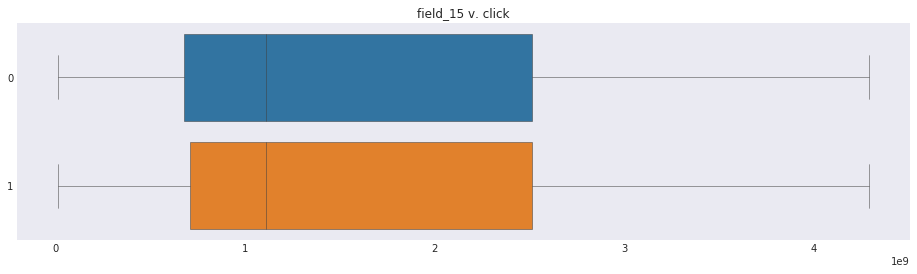

----------------------------------------------------------------------------------------------
Information for column: 16

Number of distinct values: 321438
Number of null values is: 36345


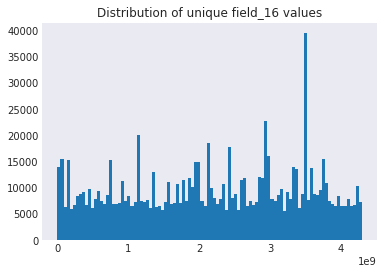

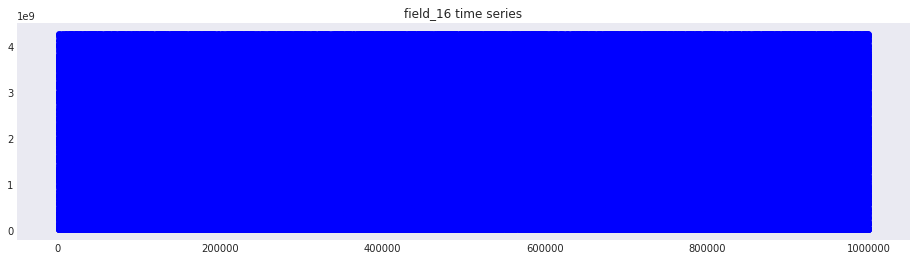

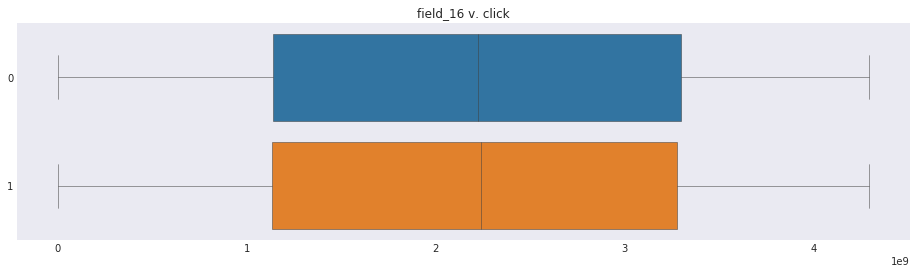

----------------------------------------------------------------------------------------------
Information for column: 17

Number of distinct values: 120964
Number of null values is: 36345


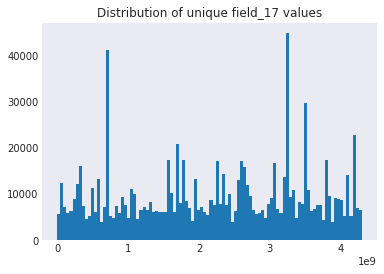

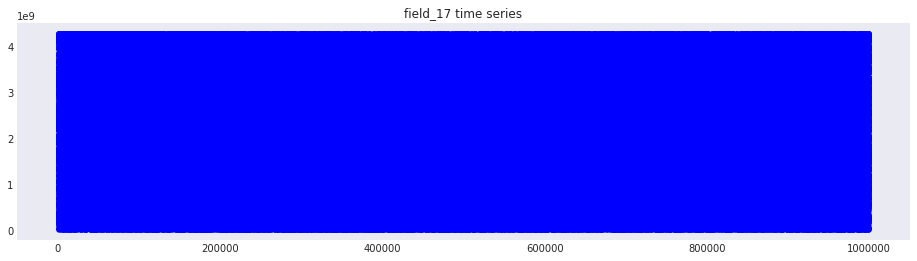

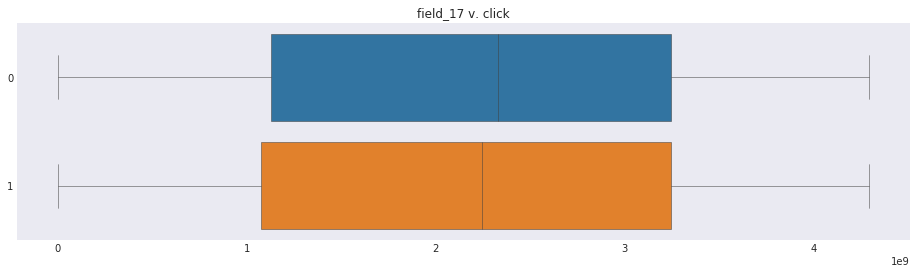

----------------------------------------------------------------------------------------------
Information for column: 18

Number of distinct values: 267
Number of null values is: 0


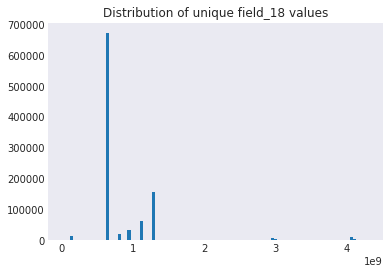

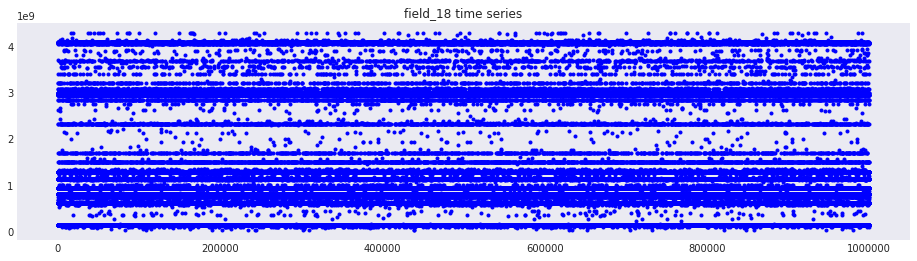

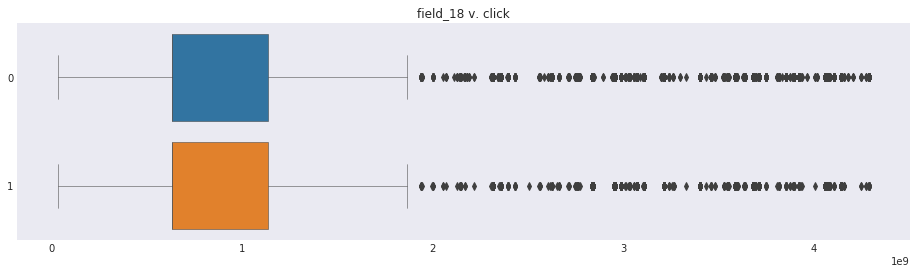

----------------------------------------------------------------------------------------------
Information for column: 19

Number of distinct values: 15
Number of null values is: 119344


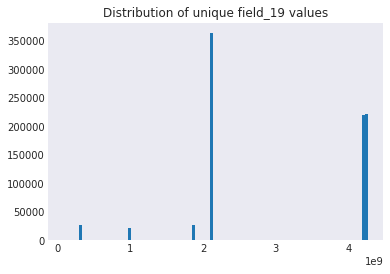

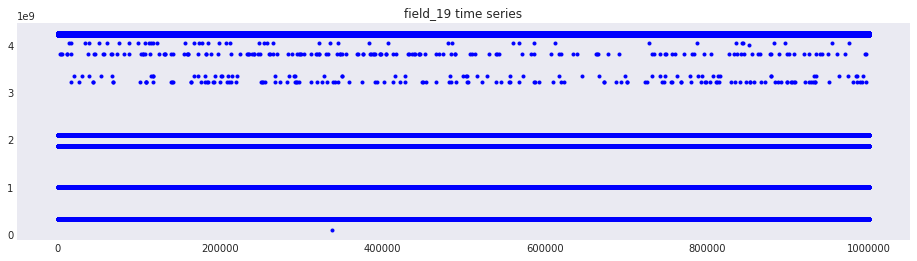

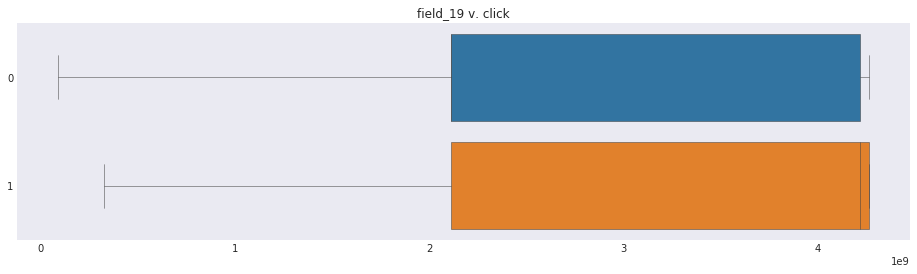

----------------------------------------------------------------------------------------------
Information for column: 20

Number of distinct values: 10863
Number of null values is: 0


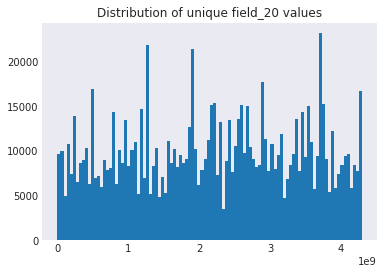

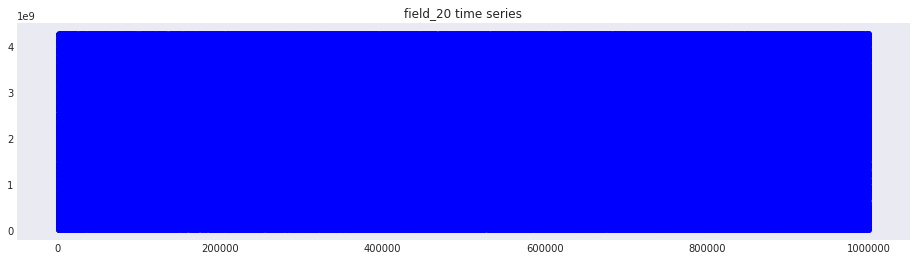

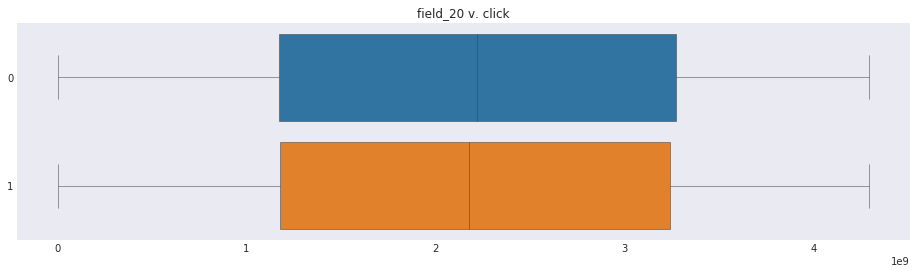

----------------------------------------------------------------------------------------------
Information for column: 21

Number of distinct values: 563
Number of null values is: 0


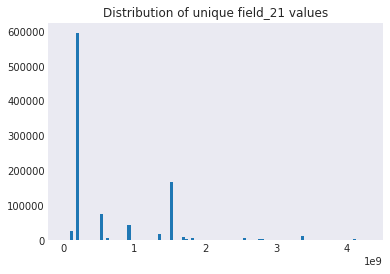

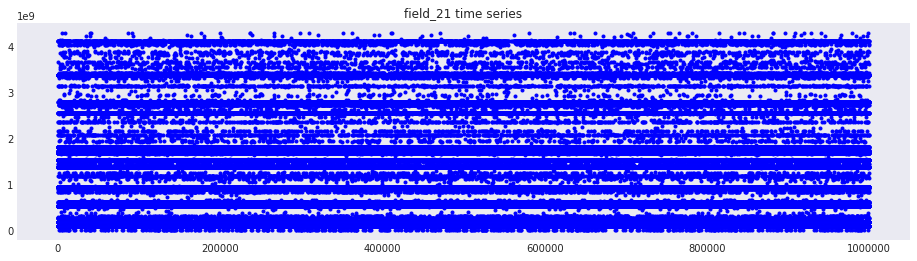

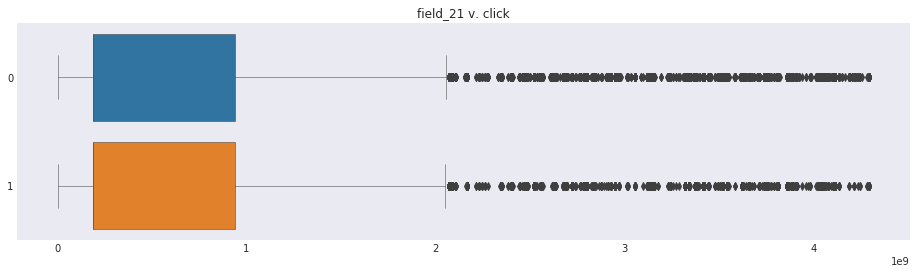

----------------------------------------------------------------------------------------------
Information for column: 22

Number of distinct values: 3
Number of null values is: 0


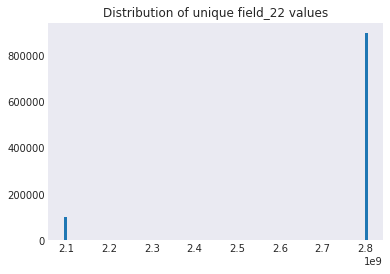

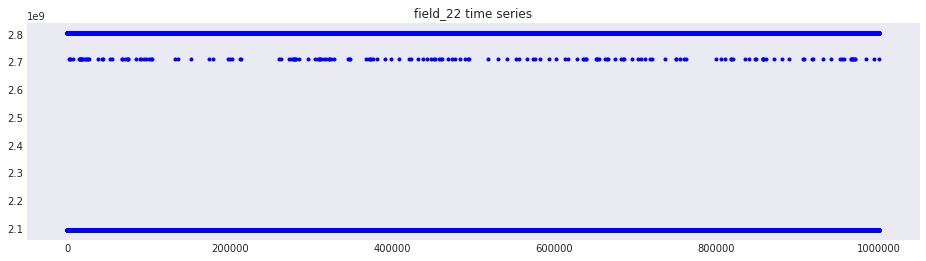

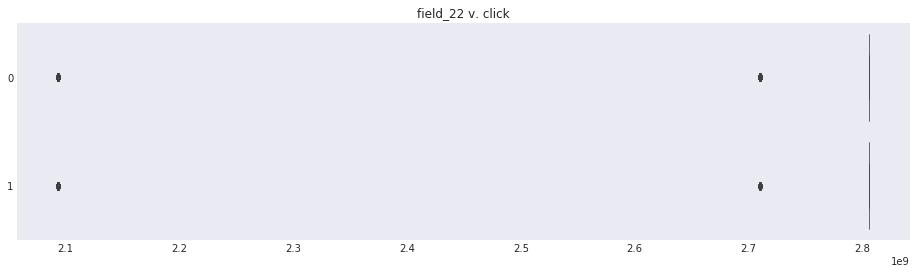

----------------------------------------------------------------------------------------------
Information for column: 23

Number of distinct values: 30792
Number of null values is: 0


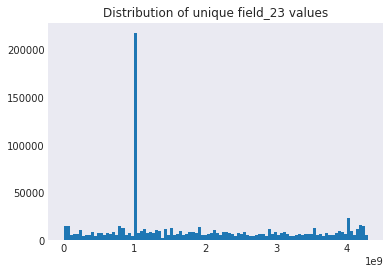

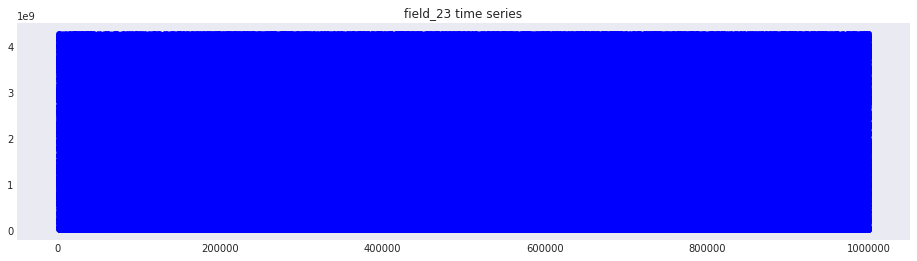

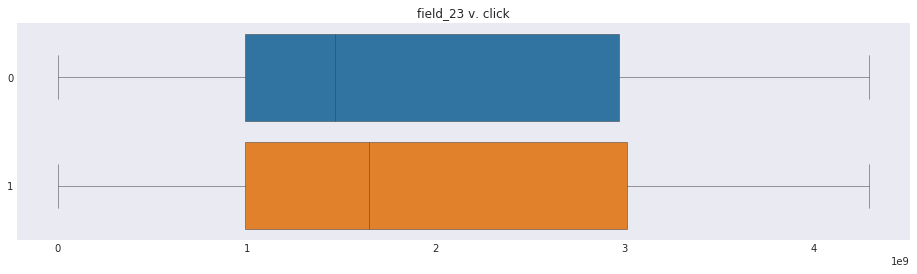

----------------------------------------------------------------------------------------------
Information for column: 24

Number of distinct values: 4731
Number of null values is: 0


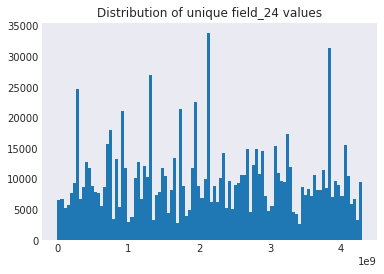

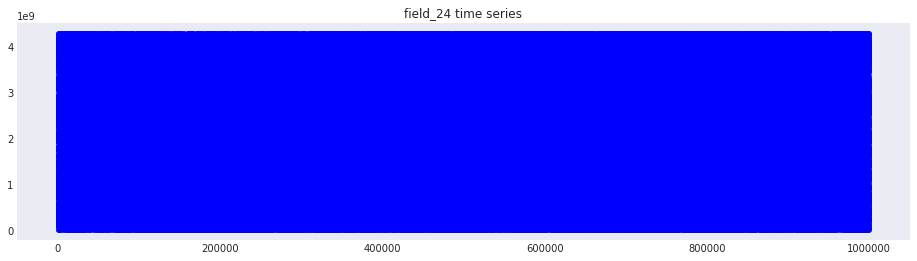

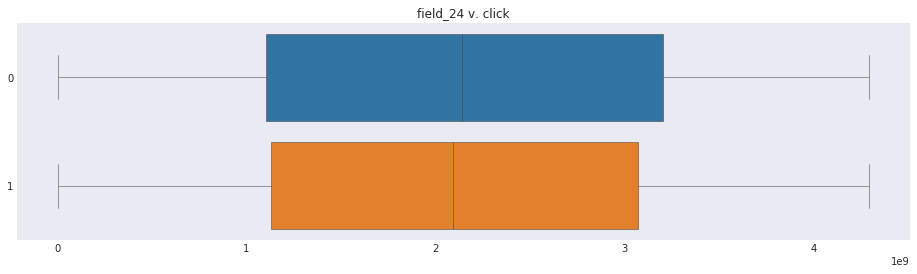

----------------------------------------------------------------------------------------------
Information for column: 25

Number of distinct values: 268487
Number of null values is: 36345


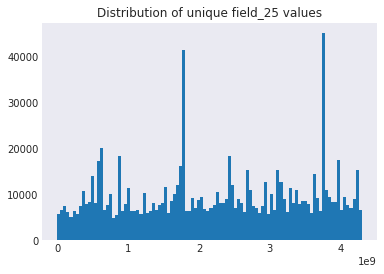

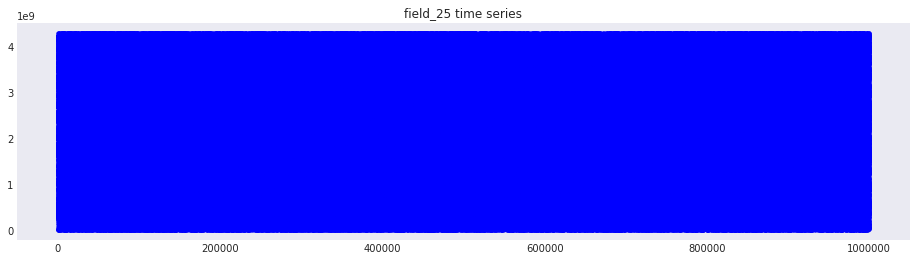

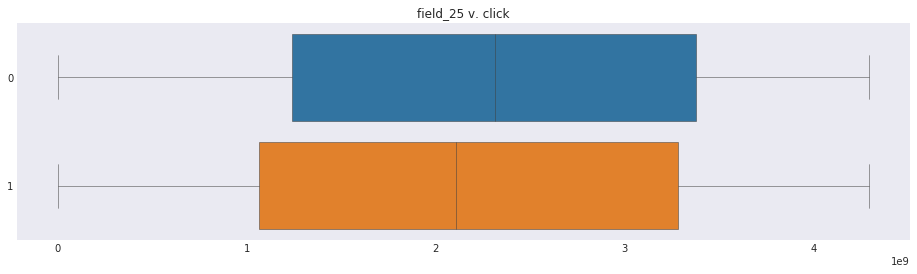

----------------------------------------------------------------------------------------------
Information for column: 26

Number of distinct values: 3068
Number of null values is: 0


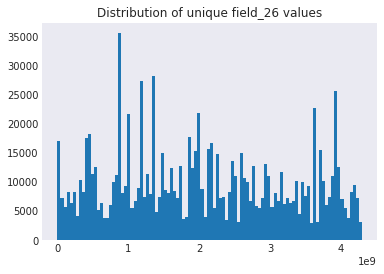

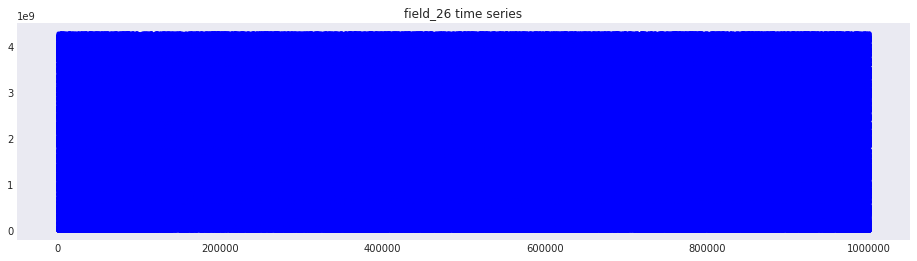

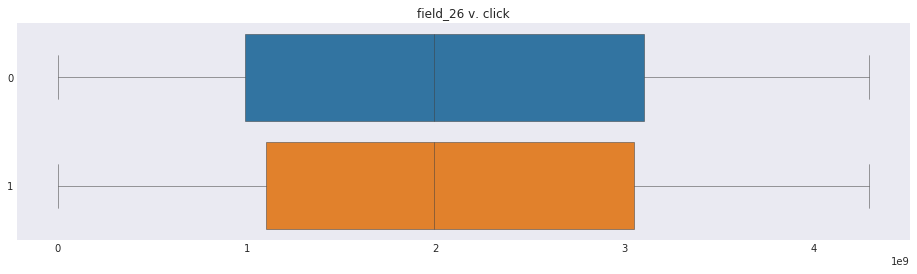

----------------------------------------------------------------------------------------------
Information for column: 27

Number of distinct values: 26
Number of null values is: 0


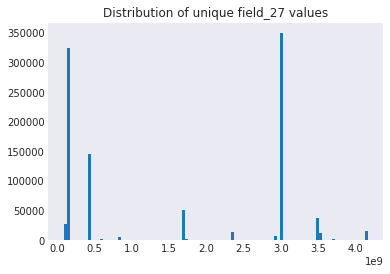

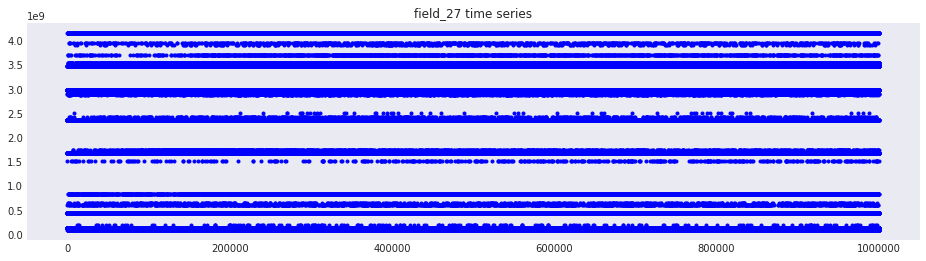

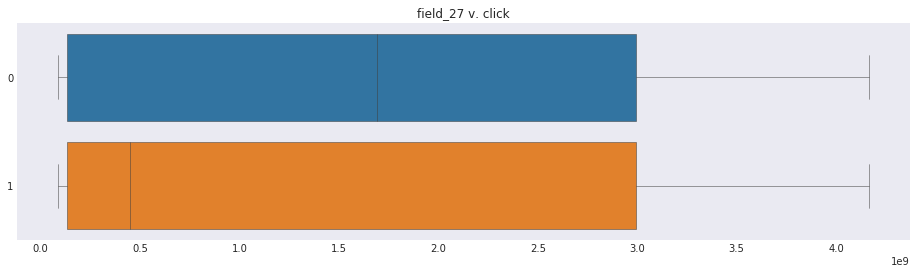

----------------------------------------------------------------------------------------------
Information for column: 28

Number of distinct values: 8934
Number of null values is: 0


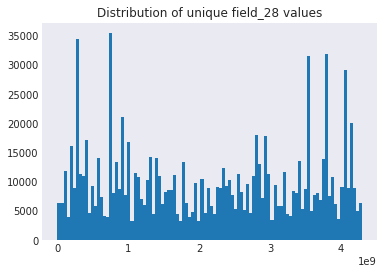

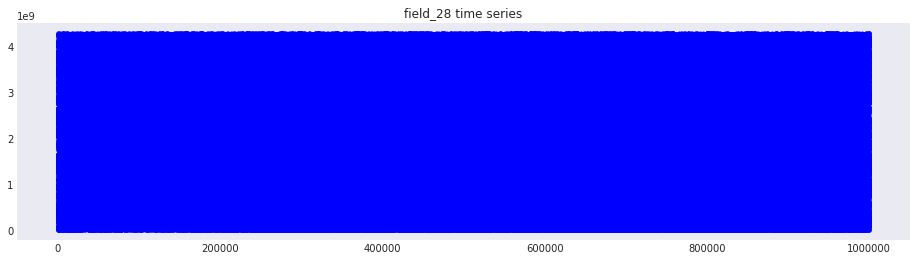

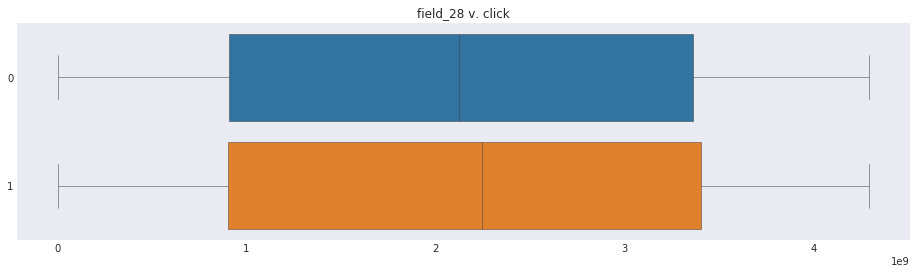

----------------------------------------------------------------------------------------------
Information for column: 29

Number of distinct values: 205923
Number of null values is: 36345


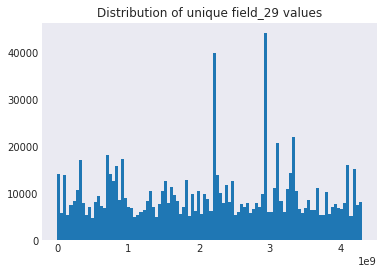

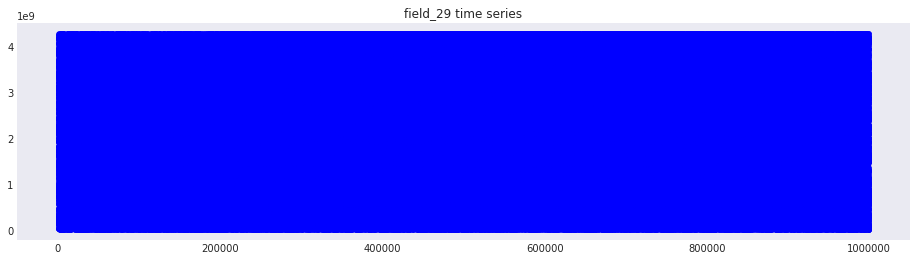

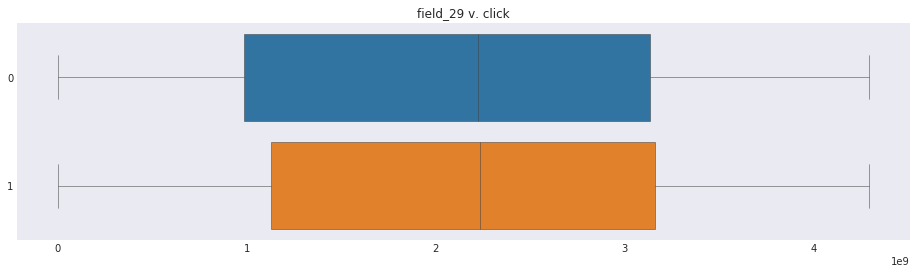

----------------------------------------------------------------------------------------------
Information for column: 30

Number of distinct values: 10
Number of null values is: 0


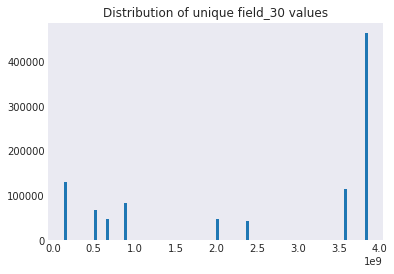

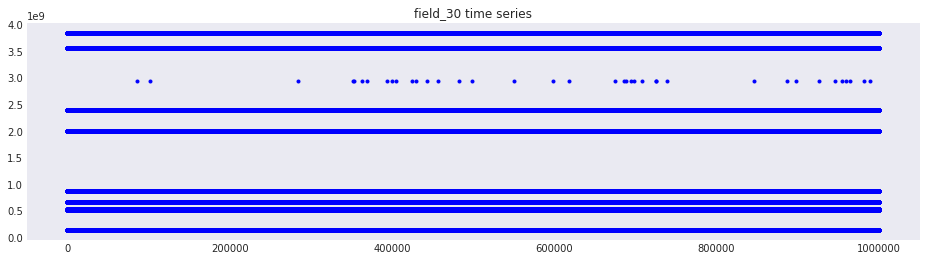

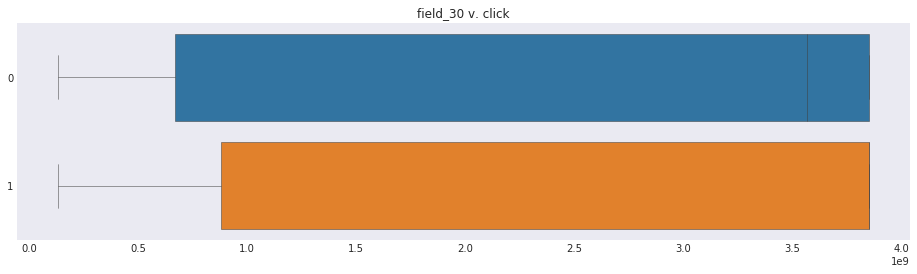

----------------------------------------------------------------------------------------------
Information for column: 31

Number of distinct values: 3881
Number of null values is: 0


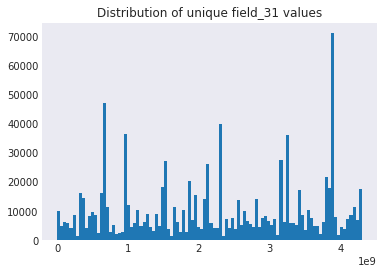

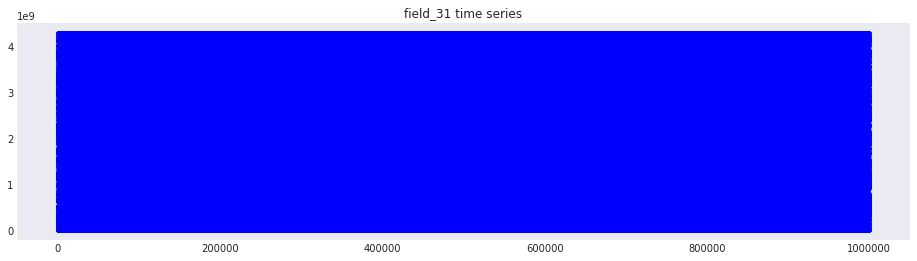

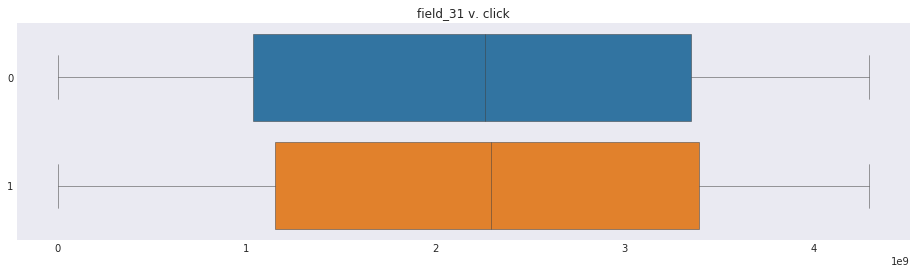

----------------------------------------------------------------------------------------------
Information for column: 32

Number of distinct values: 1854
Number of null values is: 483901


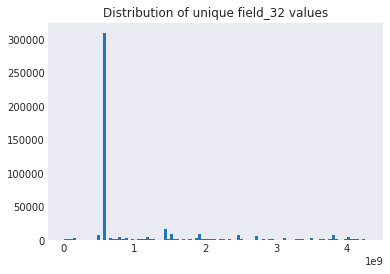

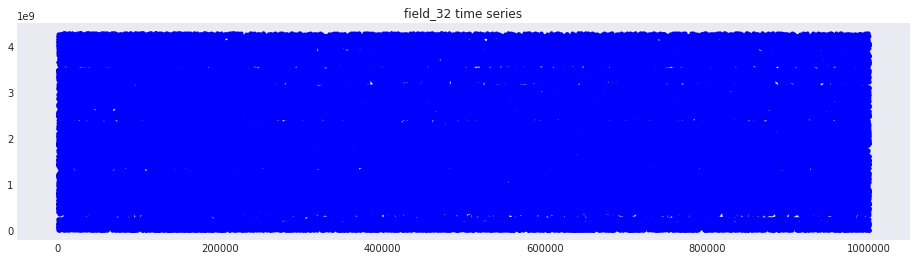

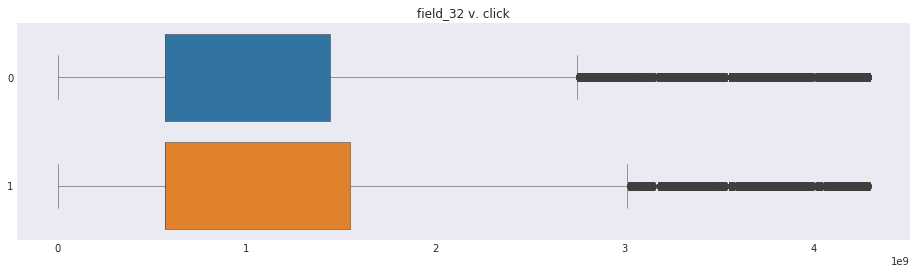

----------------------------------------------------------------------------------------------
Information for column: 33

Number of distinct values: 3
Number of null values is: 483901


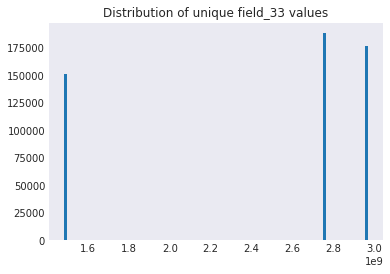

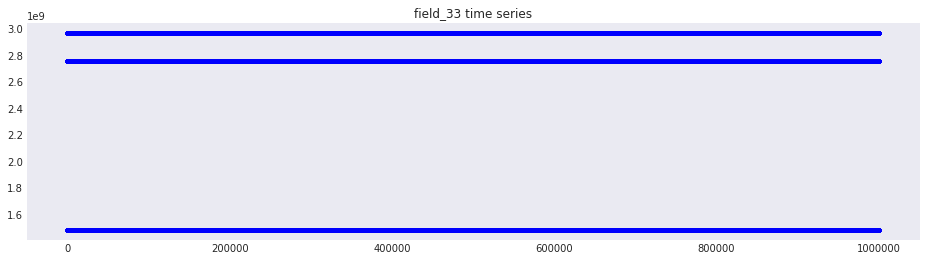

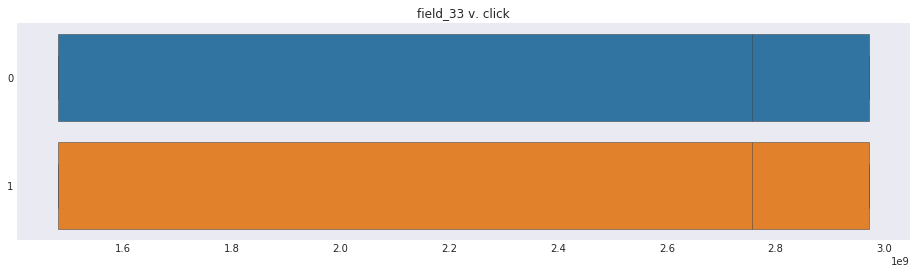

----------------------------------------------------------------------------------------------
Information for column: 34

Number of distinct values: 240747
Number of null values is: 36345


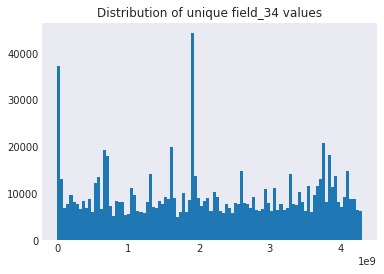

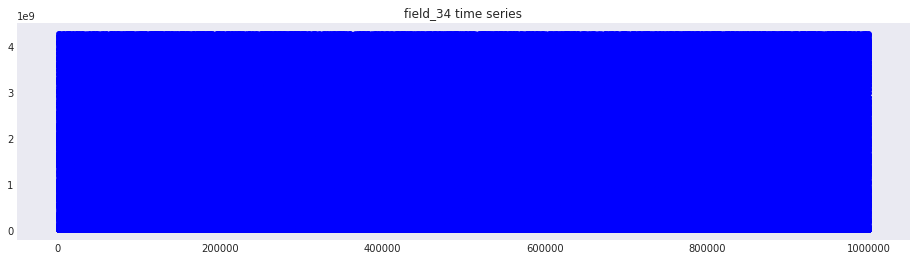

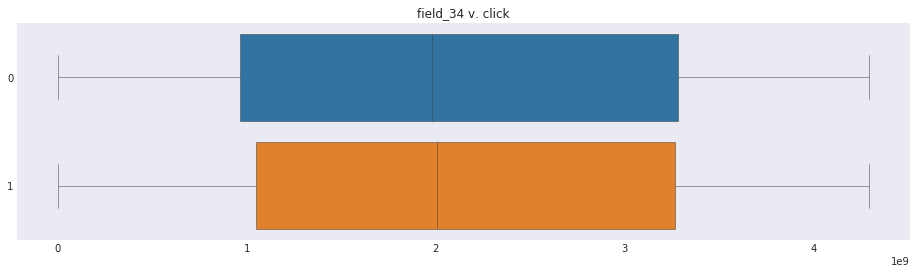

----------------------------------------------------------------------------------------------
Information for column: 35

Number of distinct values: 15
Number of null values is: 738959


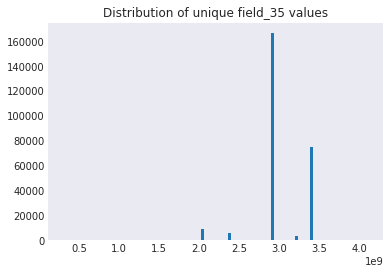

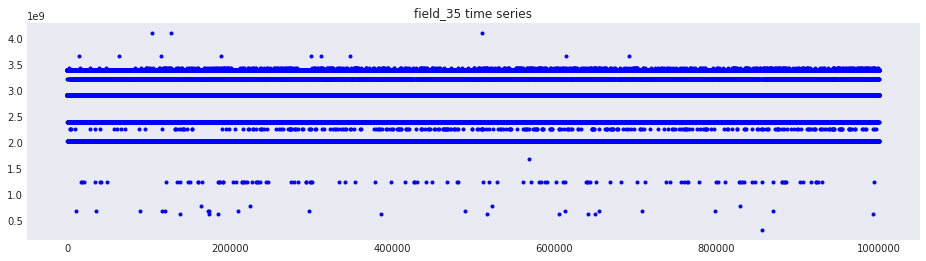

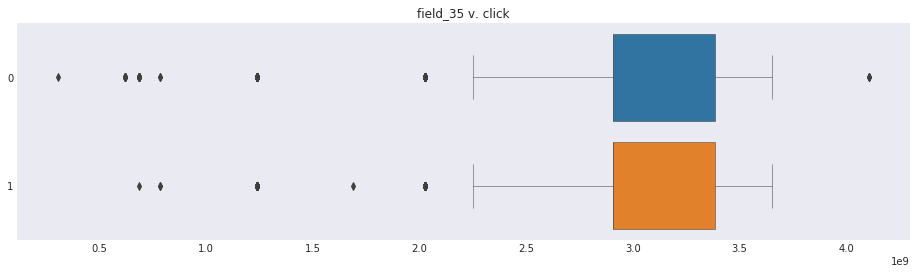

----------------------------------------------------------------------------------------------
Information for column: 36

Number of distinct values: 15
Number of null values is: 0


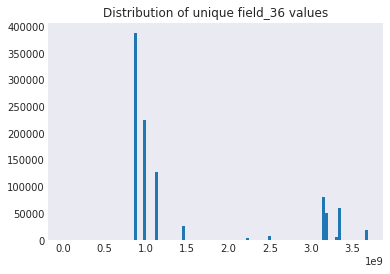

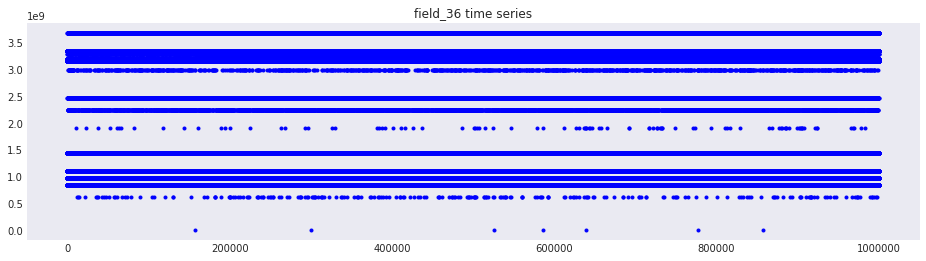

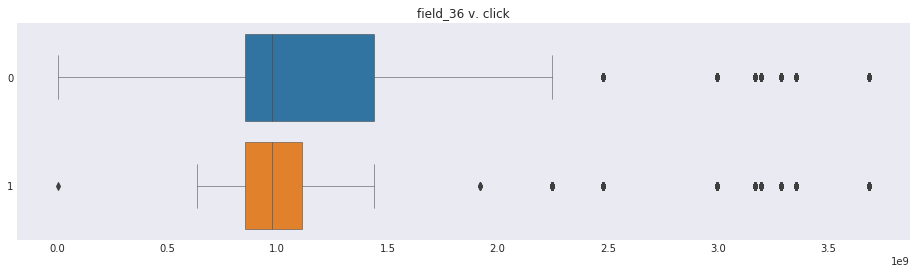

----------------------------------------------------------------------------------------------
Information for column: 37

Number of distinct values: 41282
Number of null values is: 36345


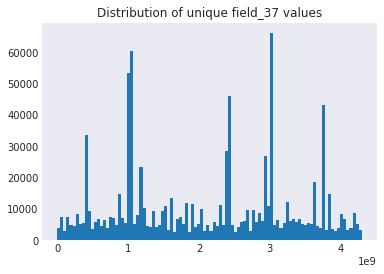

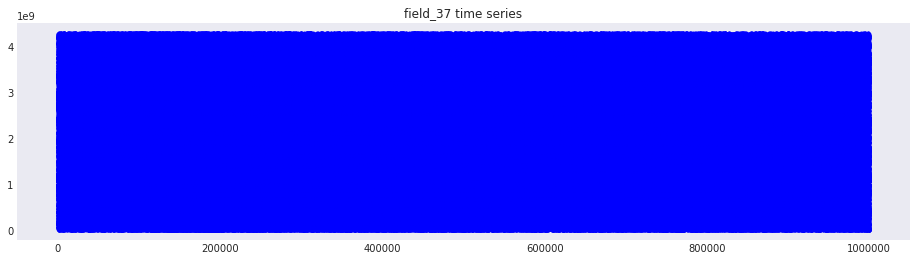

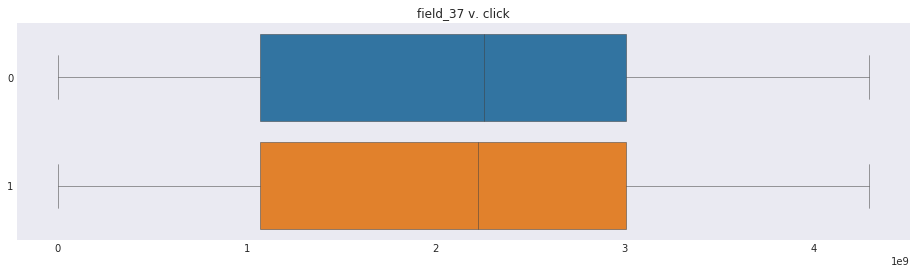

----------------------------------------------------------------------------------------------
Information for column: 38

Number of distinct values: 69
Number of null values is: 483901


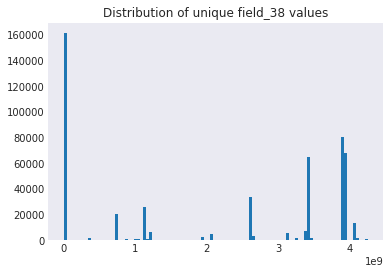

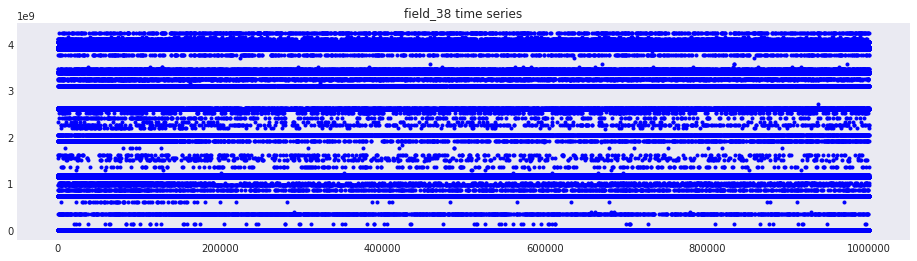

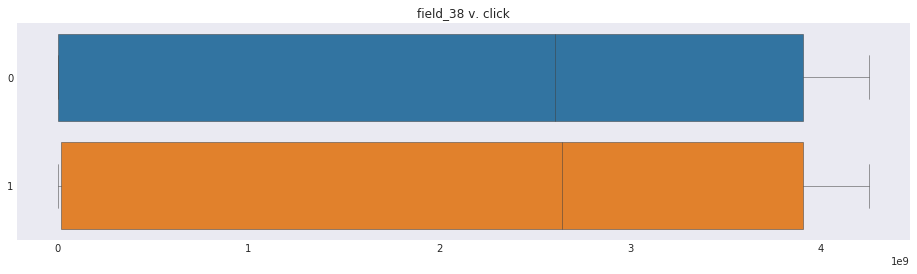

----------------------------------------------------------------------------------------------
Information for column: 39

Number of distinct values: 30955
Number of null values is: 483901


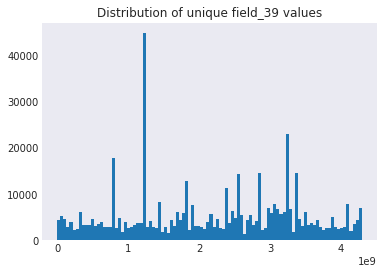

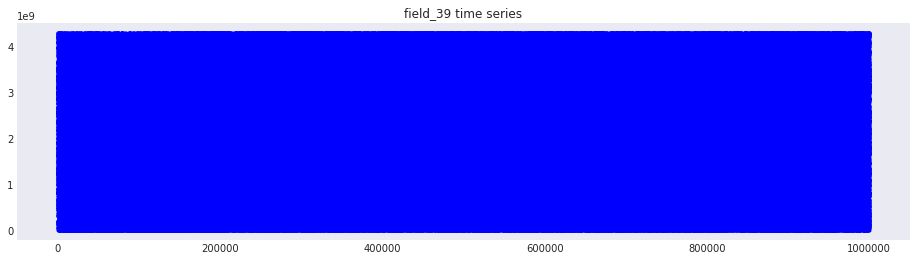

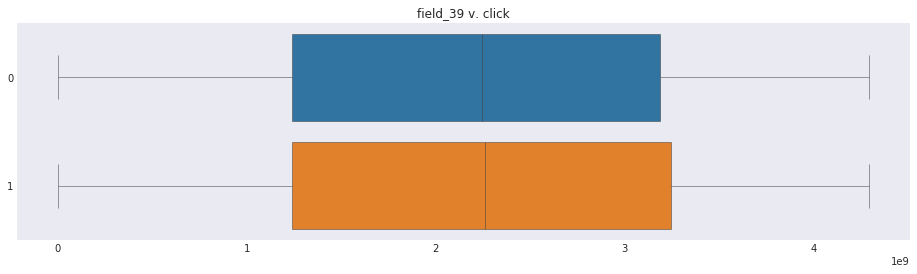

In [74]:
for num in range(numColumns):
#for num in range(2):
    print('----------------------------------------------------------------------------------------------')
    print('Information for column: {}'.format(num))
    print('')
    columnEDA(num)